# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></div><div class="lev2 toc-item"><a href="#Imports" data-toc-modified-id="Imports-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Imports</a></div><div class="lev2 toc-item"><a href="#Configs" data-toc-modified-id="Configs-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Configs</a></div><div class="lev1 toc-item"><a href="#TRAFFIC" data-toc-modified-id="TRAFFIC-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>TRAFFIC</a></div><div class="lev2 toc-item"><a href="#Load" data-toc-modified-id="Load-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load</a></div><div class="lev2 toc-item"><a href="#Validate" data-toc-modified-id="Validate-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Validate</a></div><div class="lev2 toc-item"><a href="#Analyze" data-toc-modified-id="Analyze-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Analyze</a></div><div class="lev2 toc-item"><a href="#Report" data-toc-modified-id="Report-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Report</a></div><div class="lev1 toc-item"><a href="#SOLAR" data-toc-modified-id="SOLAR-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SOLAR</a></div><div class="lev2 toc-item"><a href="#Load" data-toc-modified-id="Load-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Load</a></div><div class="lev2 toc-item"><a href="#Validate" data-toc-modified-id="Validate-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Validate</a></div><div class="lev2 toc-item"><a href="#Analyze" data-toc-modified-id="Analyze-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Analyze</a></div><div class="lev2 toc-item"><a href="#Report" data-toc-modified-id="Report-44"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Report</a></div>

# Introduction

The purpose of this notebook is to run a new error analysis on our CNN model. As of 8/1/2017, we are working with the most successful CNN model located [here](https://www.dropbox.com/home/CityMatrixSim_Data/01_machine%20learning/machine_learning_traffic_CNN_results_170723/0.2_drop_less_epochs).

This model achieved an R^2 score of 0.86 on the 3,000-city test set. But, our concern is that this metric is not exactly what we want. Instead, I would like to calculate a **percent error** on the road cells for traffic values.

At the end of the day, we want a good heatmap. So, our error metric should reflect that.

# Setup

## Imports

First, let me import all of the necessary modules for this notebook.

In [71]:
import importlib
import os
import pickle
import sys
from glob import glob

import dotmap
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

sys.path.append('../global/')
import cityiograph

In [32]:
importlib.reload(cityiograph)

<module 'cityiograph' from '../global/cityiograph.py'>

## Configs

Next, let me define any key global config vars that we will need.

# TRAFFIC

I am going to look at traffic first.

In [13]:
PICKLE_FNAME = '../../../data/new_traffic_cities/data.pkl'
PREDICTED_CITY_PATH = '../MachineLearning/runs/0.2_drop_less_epochs/predicted_cities/'

## Load

Since we have a nice pickle file with all of our data, loading it is easy!

In [5]:
data = pickle.load(open(PICKLE_FNAME, 'rb'))

`data` is a dictionary with the following keys:

In [7]:
list(data.keys())

['train_filename_list',
 'train_X',
 'val_X',
 'val_filename_list',
 'val_Y',
 'train_Y']

Now, my goal here is to calculate the [mean absolute percentage error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) of the traffic predictions on the test dataset, but only on the **road** cells.

First, I need to get this data in a format I can use.

I like using the [`dotmap`](https://pypi.python.org/pypi/dotmap) module for Python as you can quickly access dictionary elements with dot notation

In [9]:
data = dotmap.DotMap(data)

In [11]:
data.val_Y.shape

(3000, 16, 16, 2)

So, `data.val_Y` has all of the actual ground truth traffic values for our validation set. I can therefore use this to compare with the predicted model values. I need to load these into data first, though.

In [33]:
y_pred = []
for city_path in tqdm(glob(PREDICTED_CITY_PATH + '*')):
    # Get the city
    with open(city_path, 'r') as f:
        city = cityiograph.City(f.read())
    # Get the predicted values
    traffic_pred = city.get_data_matrix(key='traffic')
    y_pred.append(traffic_pred)

100%|██████████| 3000/3000 [00:08<00:00, 359.65it/s]


In [35]:
y_pred = np.array(y_pred)

In [36]:
y_pred.shape

(3000, 16, 16)

## Validate

Now, I just want to do some quick visual comparision to make sure that things line up.

In [39]:
y_true = data.val_Y[:, :, :, 0] # Traffic only

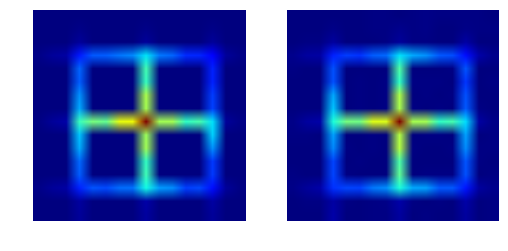

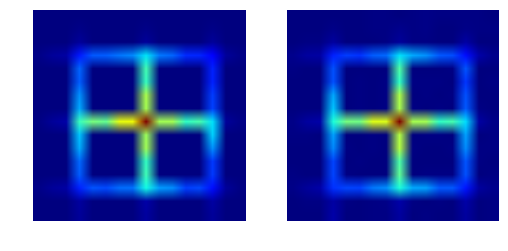

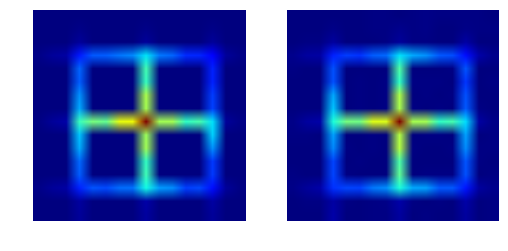

In [49]:
for count, index in enumerate(np.random.randint(low=0, high=3000, size=3)):
    plt.subplot(1, 2, 1)
    plt.imshow(y_true[0])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(y_pred[0])
    plt.axis('off')
    plt.show()

Looks good to me! Let me do some more checks just to make sure everything is lined up.

In [50]:
print(len(data.val_filename_list))

3000


In [51]:
print(len(glob(PREDICTED_CITY_PATH + '*')))

3000


In [53]:
print(data.val_filename_list[0])

../../../data/new_traffic_cities/004/SolarSimCity_7000_output.json


In [54]:
pred_files = glob(PREDICTED_CITY_PATH + '*')

In [55]:
print(pred_files[0])

../MachineLearning/runs/0.2_drop_less_epochs/predicted_cities/SolarSimCity_7000_output_predicted.json


In [63]:
true_base_names = [os.path.basename(path) for path in data.val_filename_list]
true_base_names[0]

'SolarSimCity_7000_output.json'

In [61]:
pred_base_names = [os.path.basename(path) for path in pred_files]

In [62]:
pred_base_names[0]

'SolarSimCity_7000_output_predicted.json'

In [65]:
assert all(pred_base_names[i].startswith(true_base_names[i].replace('.json', '')) for i in range(3000))

It's a match!

## Analyze

Now, it's time to calculate this error. First, let me define a function that can do this. (Taken from [StackOverflow](https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn).

In [119]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

Next, let me get the data in the format that we need it. For each city, I need to know where the roads are...

In [80]:
road_matrix = data.val_X[:, :, :, 1]
road_matrix.shape

(3000, 16, 16)

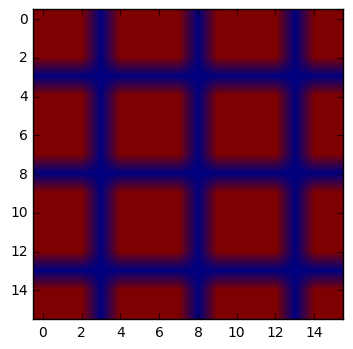

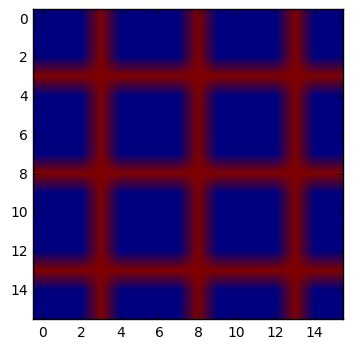

array([[False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False],
       [False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False],
       [False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False],
       [False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False],
       [False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False],
       [False, False, False,  True, False, False, False, False,  True,
        False, False, Fals

In [89]:
plt.imshow(road_matrix[0])
plt.show()
plt.imshow(road_matrix[0] == road_matrix[0].min())
plt.show()
road_matrix[0] == road_matrix[0].min()

Things are a bit odd in this array, but I can still recover the key data with some clever logic.

In [97]:
road_indicator_matrix = np.array([city == city.min() for city in road_matrix])

In [100]:
road_indicator_matrix[road_indicator_matrix == True] = 1

In [101]:
road_indicator_matrix[road_indicator_matrix == False] = 0

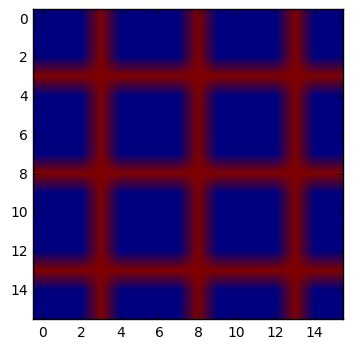

array([[False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False],
       [False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False],
       [False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False],
       [False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False],
       [False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False],
       [False, False, False,  True, False, False, False, False,  True,
        False, False, Fals

In [103]:
plt.imshow(road_indicator_matrix[0])
plt.show()
road_indicator_matrix[0]

In [105]:
indicator = np.zeros((3000, 16, 16))

In [107]:
indicator[road_indicator_matrix] = 1

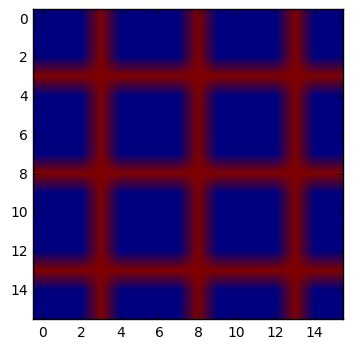

In [110]:
plt.imshow(indicator[0])
plt.show()

Now, I have a nice binary indicator matrix that I can use. Now, I must multiply this element wise with the current data matrices.

In [111]:
y_true_clipped = indicator * y_true

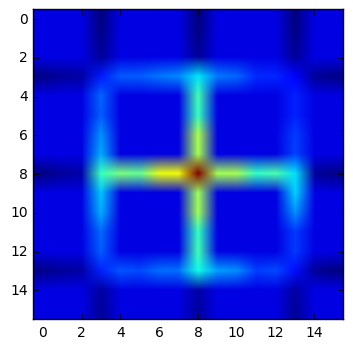

In [123]:
plt.imshow(y_true_clipped[0])
plt.show()

In [114]:
y_pred_clipped = indicator * y_pred

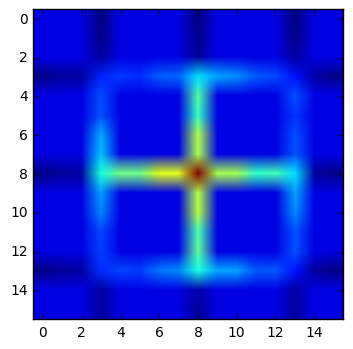

In [115]:
plt.imshow(y_pred_clipped[0])
plt.show()

Now, let me try to get the new error.

In [120]:
mean_absolute_percentage_error(y_true_clipped[0], y_pred_clipped[0])

6.5762062715265222

This is much lower!!! Now, let me do it on the full dataset.

In [121]:
naive_error = mean_absolute_percentage_error(y_true, y_pred)
print(naive_error)

21.343228337


In [122]:
real_error = mean_absolute_percentage_error(y_true_clipped, y_pred_clipped)
print(real_error)

7.15614869677


## Report

This notebook shows that our latest CNN model is able to achieve a mean absolute percentage error or just **7.16%** on the test set. Or, this is an accuracy level of **92.84%**. Great!

This lays the work for future analysis studies, model improvements and discoveries.

# SOLAR

Now, I can look at solar.

## Load

## Validate

## Analyze

## Report